<a href="https://colab.research.google.com/github/AnonymousGRLq3/GRL-Mini-Project-Q3/blob/main/2023_GRL_MiniProject_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GRL Mini-project Question 3 - Michaelmas term 2023**

Edit the code block below to the download the version of torch installed on this system

In [ ]:
%env TORCH=2.1.0+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

env: TORCH=2.1.0+cu118
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 20.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import random
import copy

# Model Construction

GNNLayer is a standard MPNN layer with an additional auxillery term which computes either nothing at all, the implicit edge message, or the connected component message depending on the layer_type.

In [ ]:
class GNNLayer(nn.Module):

    def __init__(self, layer_type, input_dim, output_dim):
      super().__init__()
      self.input_dim = input_dim
      self.output_dim = output_dim
      self.layer_type = layer_type

      self.W_self = nn.Linear(input_dim, output_dim, bias=True)
      self.W_neigh = nn.Linear(input_dim, output_dim, bias=False)
      if layer_type != 'standard':
        self.W_aux = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, node_feats, adj_matrix, aux_matrix = None):
      if aux_matrix == None or self.layer_type == 'standard':
        X = self.W_self(node_feats) + self.W_neigh(adj_matrix @ node_feats)
      else:
        X = self.W_self(node_feats) + self.W_neigh(adj_matrix @ node_feats) + self.W_aux(aux_matrix @ node_feats)
      return X

GNN stacks num_layer GNNLayers with hidden dimension hidden_dim, output dimension g_output_dim, and layer_type set as model_type. Then, a pooling function is applied to produce a graph representation, and an MLP is applied to the graph representation. The depth and width of the MLP is specified by MLP_depth and MLP_hid_dim, and the final output dimension of the entire model is specified by num_classes.

In [ ]:
class GNN(nn.Module):

    def __init__(self, model_type, input_dim, hidden_dim, g_output_dim, num_classes, num_layers=2, act_fn=nn.ReLU, pooling = "sum", MLP_depth = 1, MLP_hid_dim=6):
      super().__init__()
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.g_output_dim = g_output_dim
      self.num_layers = num_layers
      self.act_fn = act_fn()
      self.pooling = pooling
      self.MLP_depth = MLP_depth
      self.MLP_hid_dim = MLP_hid_dim
      self.model_type = model_type

      self.GNN_layers = nn.ModuleList()
      self.MLP_layers = nn.ModuleList()

      if num_layers == 1:
        self.GNN_layers.append(GNNLayer(model_type, input_dim, g_output_dim))
      else:
        ph_in = input_dim
        ph_out = hidden_dim
        for i in range(num_layers):
          if i == 1:
            ph_in = hidden_dim
          if i == (num_layers - 1):
            ph_out = g_output_dim
          self.GNN_layers.append(GNNLayer(model_type, ph_in, ph_out))

      if MLP_depth == 1:
        self.MLP_layers.append(nn.Linear(g_output_dim, num_classes))
      else:
        ph_in = g_output_dim
        ph_out = MLP_hid_dim
        for i in range(MLP_depth):
          if i == 1:
            ph_in = MLP_hid_dim
          if i == (MLP_depth - 1):
            ph_out = num_classes
          self.MLP_layers.append(nn.Linear(ph_in, ph_out))

    def forward(self, x, adj_matrix, aux_matrix = None):
      for l in self.GNN_layers:
        x = self.act_fn(l(x, adj_matrix, aux_matrix = aux_matrix))
      if self.pooling == "sum":
        x = torch.sum(x, dim=0)
      elif self.pooling == "mean":
        x = torch.mean(x, dim=0)
      elif self.pooling == "max":
        x = torch.max(x,0)[0]
      for i in range(self.MLP_depth - 1):
        x = self.act_fn(self.MLP_layers[i](x))
      x = self.MLP_layers[-1](x)
      return x

We declare hyperparameters.

In [ ]:
params = {
    "input_dim" : 15,
    "hidden_dim": 25,
    "MLP_depth": 3,
    "MLP_hid_dim": 10,
    "g_output_dim" : 15,
    "num_classes" :  10,
    "act_fn" : nn.ReLU,
    "pooling" : "sum",
    "num_layers": 2,
    "learning_rate": 1e-4,
    "batch_size" : 1500,
    "batch_shuffle": True,
    "num_epochs": 500,
    "beta": 0.4
}

We initialize three models: standard_model is an MPNN with standard neighborhood message aggregation, implicit_model is an MPNN with neighborhood message passing as well as additional weighted message passing along implicit edges computed by s_katz, and connected_model is an MPNN with neighborhood message passing as well as additional message passing from non-neighbors in the connected component.

In [ ]:
standard_model = GNN("standard", params["input_dim"], params["hidden_dim"], params["g_output_dim"], params["num_classes"],
                    num_layers = params["num_layers"], act_fn = params["act_fn"], pooling = params["pooling"], MLP_depth = params["MLP_depth"], MLP_hid_dim = params["MLP_hid_dim"])

In [ ]:
implicit_model = GNN("implicit", params["input_dim"], params["hidden_dim"], params["g_output_dim"], params["num_classes"],
                    num_layers = params["num_layers"], act_fn = params["act_fn"], pooling = params["pooling"], MLP_depth = params["MLP_depth"], MLP_hid_dim = params["MLP_hid_dim"])

In [ ]:
connected_model = GNN("connected", params["input_dim"], params["hidden_dim"], params["g_output_dim"], params["num_classes"],
                    num_layers = params["num_layers"], act_fn = params["act_fn"], pooling = params["pooling"], MLP_depth = params["MLP_depth"], MLP_hid_dim = params["MLP_hid_dim"])

# Dataset Construction

s_katz computes the Katz global overlap statistic of a graph given its adjacency matrix.

impl_edges filters the katz index matrix so that diagonal entries and entires corresponding to a nodes neighbors are set to zero (i.e we only output Katz index measures for each nodes non-neighbors).

conn_comp takes in a nx graph and outputs a matrix that indicates each nodes non-neighbors within the node's connected component.

In [ ]:
def s_katz(adj_matrix, beta):
  d = len(adj_matrix)
  I = torch.eye(d)
  S = torch.inverse(I - (beta * adj_matrix)) - I
  return S

def impl_edges(adj_matrix, beta):
  d = len(adj_matrix)
  I = torch.eye(d)
  S = s_katz(adj_matrix, beta)
  ones = torch.ones((d, d))
  indicator = ones - adj_matrix - I
  return S * indicator

def conn_comp(graph):
  connected_comps = list(nx.connected_components(graph))
  d = nx.number_of_nodes(graph)
  I = torch.eye(d)
  A = torch.tensor(nx.to_numpy_array(graph)).float()
  C = torch.zeros((d,d))
  for comp in connected_comps:
    lcomp = list(comp)
    for node in lcomp:
      C[node][lcomp] = 1
  return C-I-A

cycle_lengthes generates all the integer partitions of n that do not include 1 or 2 (no graph with less than 3 nodes can be a cycle graph).

gen_cycle_graphs generates all graphs on n nodes that can be expressed as a disjoint union of cycle graphs (using the cycle lengthes determined by cycle_lengthes).

display_cycle_graphs can be used to plot the graphs generated by gen_cycle_graphs for a certain n.

gen_cycle_dataset generates the dataset we will train our models on: each datapoint in the generated set consists of a node features matrix (all initial feature vectors are set to 1^d), an adjacency matrix, an implicit edge matrix (Katz index filtered to only include non-neighbors), a connected component matrix, and a target label which corresponds to the number of connected components in the graph. The dataset contains such datapoints for all disjoint unions of cycle graphs on n nodes for every n in the interval [n_start, n_end]. gen_cycle_dataset also outputs a vector that expresses how many graphs in the dataset fall into each target class.

display_datapoint plots the graph corresponding to a particular datapoint in a generated dataset, as well as printing the initial node features, adjacency matrix, implicit edge matrix, connected component matrix, and target label.

In [ ]:
def cycle_lengthes(n):
    def int_parts(n):
        if n == 0:
            yield []
            return
        for p in int_parts(n - 1):
            yield [1] + p
            if len(p) > 0 and (len(p) == 1 or p[1] > p[0]):
                yield [p[0] + 1] + p[1:]
    filtered = []
    for p in list(int_parts(n)):
      if 1 not in p and 2 not in p:
        filtered.append(p)
    return filtered

def gen_cycle_graphs(n):
  partitions = cycle_lengthes(n)
  graphs = []
  for lengthes in partitions:
    components = []
    for length in lengthes:
      components.append(nx.cycle_graph(length))
    graphs.append(nx.disjoint_union_all(components))
  return graphs

def display_cycle_graphs(n):
  graphs = gen_cycle_graphs(n)
  for i in range(len(graphs)):
      plt.figure()
      plt.title(f"Graph {i+1}")
      nx.draw(graphs[i], with_labels=True, node_color='skyblue', font_weight='bold')
      plt.show()

def gen_cycle_dataset(n_start, n_end, d=4):
  dataset = []
  max_partitions = cycle_lengthes(n_end)
  num_comps = []
  for part in max_partitions:
    num_comps.append(len(part))
  n_classes = max(num_comps)
  y_count = torch.zeros(n_classes)
  for n in range(n_start, n_end+1):
    graphs = gen_cycle_graphs(n)
    for graph in graphs:
      X = torch.ones((n, d))
      A = torch.tensor(nx.to_numpy_array(graph)).float()
      Impl_mat = impl_edges(A,params["beta"])
      Comp_mat = conn_comp(graph)
      y = torch.zeros(n_classes)
      c = nx.number_connected_components(graph)-1
      y[c] = 1
      y_count[c] += 1
      dataset.append({'X':X, 'A': A ,'Impl_mat': Impl_mat,"Comp_mat": Comp_mat, 'y': y})

  return dataset, y_count, y_count/torch.sum(y_count).item()

def display_datapoint(dataset, n):
  datapoint = dataset[n]
  G = nx.from_numpy_array(datapoint['A'].numpy())
  X = datapoint['X']
  A = datapoint['A']
  Impl_mat = datapoint['Impl_mat']
  Comp_mat = datapoint['Comp_mat']
  y = datapoint['y']
  nx.draw(G, with_labels=True, node_color='skyblue', font_weight='bold')
  plt.show
  print(f"Node features: {X}")
  print(f"Adjacency matrix: {A}")
  print(f"Implicit matrx: {Impl_mat}")
  print(f"Connected component matrix: {Comp_mat}")
  print(f"Class: {y}")

We generate out dataset.

In [ ]:
dataset, class_count, class_dist = gen_cycle_dataset(6,30, d=params["input_dim"])

We display a datapoint to check that our dataset is properly generated.

Node features: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
     

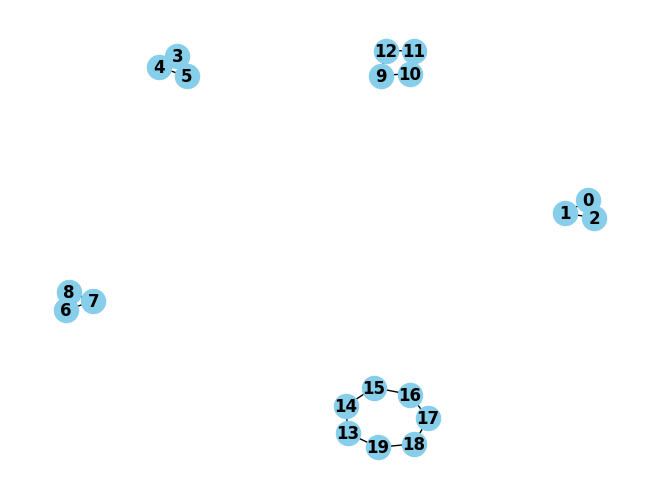

In [ ]:
display_datapoint(dataset,200)

In [ ]:
print(len(dataset))

1882


# Experiments

In both the evaluate and train functions, model_type of the inputted model is used to determine which auxillary matrix is used by the model to perform predictions.

In [ ]:
def evaluate(model, data):
  model.eval()
  correct = 0
  total = 0
  for graph in data:
    if model.model_type == 'standard':
      aux = None
    elif model.model_type == "implicit":
      aux = graph["Impl_mat"]
    elif model.model_type == "connected":
      aux = graph["Comp_mat"]
    pred = model(graph['X'], graph['A'], aux_matrix = aux)
    if pred.argmax() == graph['y'].argmax():
      correct += 1
    total += 1
  return correct/total

In [ ]:
def train(model, data, params, print_every=10, record_accuracies = True, record_every = 10, save_best_model = True, check_best_every = 10):
  loss_fn = nn.CrossEntropyLoss()
  opt = torch.optim.AdamW(model.parameters(), lr=params["learning_rate"])
  if record_accuracies:
    accuracies = []
    record_epoch_list = []
  if save_best_model:
    best_model_temp = None
    acc_temp = 0
    epoch_temp = 0
  for epoch in range(params["num_epochs"]):
    model.train()
    print_epoch = True if epoch % print_every == 0 or epoch == params["num_epochs"]-1 else False
    record_epoch = True if record_accuracies and (epoch % record_every == 0 or epoch == params["num_epochs"]-1) else False
    check_best_epoch = True if save_best_model and (epoch % check_best_every == 0 or epoch == params["num_epochs"]-1) else False
    eval_time = print_epoch or record_epoch or check_best_epoch
    if print_epoch:
      losses = []
    data_batch = random.sample(data, params["batch_size"]) if params["batch_shuffle"] == True else data
    for graph in data_batch:
        if model.model_type == 'standard':
          aux = None
        elif model.model_type == "implicit":
          aux = graph["Impl_mat"]
        elif model.model_type == "connected":
          aux = graph["Comp_mat"]
        opt.zero_grad()
        pred = model(graph['X'], graph['A'], aux_matrix = aux)
        loss = loss_fn(pred, graph['y'])
        if print_epoch:
          losses.append(loss.item())
        loss.backward()
        opt.step()
    if eval_time:
        acc = evaluate(model, data)
        if check_best_epoch and (best_model_temp == None or acc >= acc_temp):
            acc_temp = acc
            best_model_temp = copy.deepcopy(model)
            epoch_temp = epoch
        if print_epoch:
          print(f"epoch={epoch}, avg loss={sum(losses)/len(losses)}, accuracy={acc}")
        if record_epoch:
          accuracies.append(acc)
          record_epoch_list.append(epoch)
  if save_best_model or record_accuracies:
    ret = []
    if save_best_model:
      ret.append(best_model_temp)
      ret.append(epoch_temp)
    if record_accuracies:
      ret.append(accuracies)
      ret.append(record_epoch_list)
    return ret

In [ ]:
standard_model, s_from_epoch, standard_accs, standard_epochs = train(standard_model, dataset, params)

epoch=0, avg loss=2.334573226292928, accuracy=0.21679064824654623
epoch=10, avg loss=1.781818142414093, accuracy=0.2736450584484591
epoch=20, avg loss=1.7880013696352641, accuracy=0.2736450584484591
epoch=30, avg loss=1.759938505411148, accuracy=0.28002125398512223
epoch=40, avg loss=1.7905985450744628, accuracy=0.27683315621679067
epoch=50, avg loss=1.7682011168003082, accuracy=0.27683315621679067
epoch=60, avg loss=1.7738708214759826, accuracy=0.2747077577045696
epoch=70, avg loss=1.7877865071296692, accuracy=0.28374070138150903
epoch=80, avg loss=1.7646165203253428, accuracy=0.28374070138150903
epoch=90, avg loss=1.7703385162353515, accuracy=0.28374070138150903
epoch=100, avg loss=1.7680024700959525, accuracy=0.2821466524973433
epoch=110, avg loss=1.770301618417104, accuracy=0.28746014877789583
epoch=120, avg loss=1.754766570409139, accuracy=0.28746014877789583
epoch=130, avg loss=1.770507360537847, accuracy=0.2895855472901169
epoch=140, avg loss=1.7623832324345907, accuracy=0.28905

In [ ]:
implicit_model, i_from_epoch, implicit_accs, implicit_epochs = train(implicit_model, dataset, params)

epoch=0, avg loss=2.0415773417552314, accuracy=0.34378320935175344
epoch=10, avg loss=1.1323952037890752, accuracy=0.5191285866099894
epoch=20, avg loss=1.033726703564326, accuracy=0.5488841657810839
epoch=30, avg loss=0.9743720439871152, accuracy=0.5749202975557917
epoch=40, avg loss=0.961688718477885, accuracy=0.5871413390010627
epoch=50, avg loss=0.9232634345988433, accuracy=0.5557917109458024
epoch=60, avg loss=0.892634603569905, accuracy=0.59192348565356
epoch=70, avg loss=0.873331571171681, accuracy=0.5180658873538788
epoch=80, avg loss=0.8451366726656755, accuracy=0.5738575982996812
epoch=90, avg loss=0.8448842168202003, accuracy=0.5988310308182784
epoch=100, avg loss=0.8199973350663979, accuracy=0.614240170031881
epoch=110, avg loss=0.8101751894056797, accuracy=0.6498405951115834
epoch=120, avg loss=0.7579833870132764, accuracy=0.5913921360255048
epoch=130, avg loss=0.7360874329159657, accuracy=0.6588735387885228
epoch=140, avg loss=0.7303029209921758, accuracy=0.66896918172157

In [ ]:
connected_model, c_from_epoch, connceted_accs, connected_epochs = train(connected_model, dataset, params)

epoch=0, avg loss=2.298110867717032, accuracy=0.23698193411264612
epoch=10, avg loss=0.8717394460613529, accuracy=0.6360255047821467
epoch=20, avg loss=0.8068547580596059, accuracy=0.6631243358129649
epoch=30, avg loss=0.7361181779390705, accuracy=0.6891604675876727
epoch=40, avg loss=0.7190878999816874, accuracy=0.6902231668437833
epoch=50, avg loss=0.6970467035258189, accuracy=0.6849096705632306
epoch=60, avg loss=0.6977899154595409, accuracy=0.6827842720510096
epoch=70, avg loss=0.6875495110461488, accuracy=0.6907545164718385
epoch=80, avg loss=0.6582434204344948, accuracy=0.6636556854410202
epoch=90, avg loss=0.6547454633346448, accuracy=0.6886291179596175
epoch=100, avg loss=0.6441203659911019, accuracy=0.7008501594048884
epoch=110, avg loss=0.6455662904245159, accuracy=0.6976620616365569
epoch=120, avg loss=0.6394834449486807, accuracy=0.6859723698193412
epoch=130, avg loss=0.6308738688146696, accuracy=0.7066950053134963
epoch=140, avg loss=0.6110402674879103, accuracy=0.70297555

We save our trained models.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
torch.save(standard_model.state_dict(), "/content/gdrive/My Drive/{standard_model_params2}")

In [ ]:
torch.save(implicit_model.state_dict(), "/content/gdrive/My Drive/{implicit_model_params2}")

In [ ]:
torch.save(connected_model.state_dict(), "/content/gdrive/My Drive/{connected_model_params2}")

We print the highest accuracies achieved by each model, along with the epoch that this accuracy is achieved at.

In [ ]:
print(evaluate(standard_model, dataset))
print(s_from_epoch)

0.2948990435706695
480


In [ ]:
print(evaluate(implicit_model, dataset))
print(i_from_epoch)

0.9782146652497343
480


In [ ]:
print(evaluate(connected_model, dataset))
print(c_from_epoch)

0.9941551540913921
470


# Results

We plot accuracies for each model

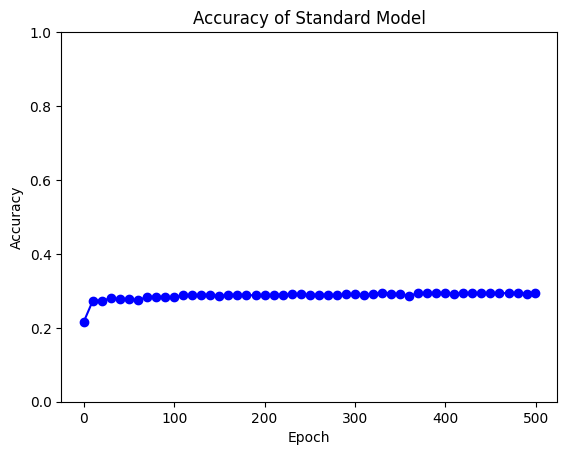

In [ ]:
plt.plot(standard_epochs, standard_accs, marker='o', linestyle='-', color='blue', label='Line Plot')
plt.title('Accuracy of Standard Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.show()

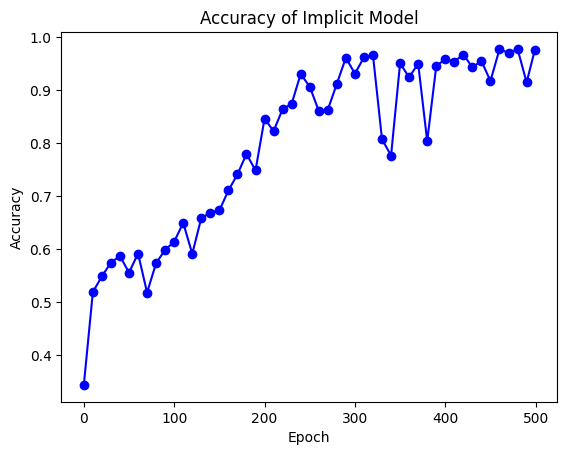

In [ ]:
plt.plot(implicit_epochs, implicit_accs, marker='o', linestyle='-', color='blue', label='Line Plot')
plt.title('Accuracy of Implicit Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

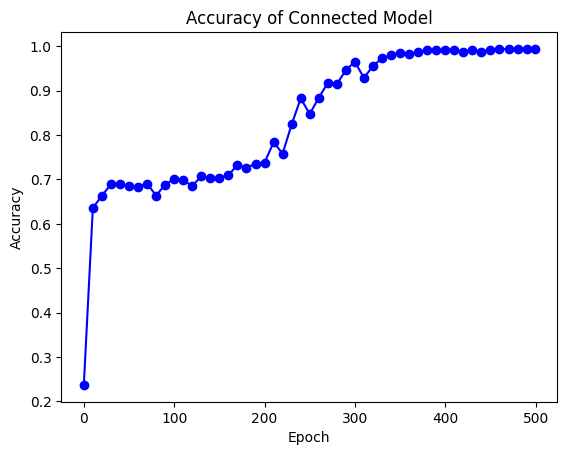

In [ ]:
plt.plot(connected_epochs, connceted_accs, marker='o', linestyle='-', color='blue', label='Line Plot')
plt.title('Accuracy of Connected Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

We check what predictions the standard_model is making for each n.

In [ ]:
def check_model_for_each_n(n_start, n_end, model):
  model.eval()
  pred_for_all_N = []
  Nlist = []
  for N in range(n_start, n_end+1):
    Ndata, _, Nclass_dist = gen_cycle_dataset(N,N, d=params["input_dim"])
    Nlength = len(Ndata)
    most_class = torch.argmax(Nclass_dist, dim=0)
    pred = []
    for graph in Ndata:
      if model.model_type == 'standard':
        aux = None
      elif model.model_type == "implicit":
        aux = graph["Impl_mat"]
      elif model.model_type == "connected":
        aux = graph["Comp_mat"]
      pred.append(model(graph['X'], graph['A'], aux_matrix = aux))
    all_identical = all(torch.equal(pred[0], row) for row in pred)
    if all_identical:
      pred_for_all_N.append((torch.argmax(pred[0], dim=0)).item()+1)
      print(f'Model predicts {torch.argmax(pred[0], dim=0)+1} connected components for all graphs on {N} nodes, while the plurality of graphs on {N} nodes have {most_class+1} components')
    else:
      pred_for_all_N.append(-1)
      print(f'Model can distinguish predictions for certain graphs on {N} nodes')
    Nlist.append(N)
  return pred_for_all_N, Nlist


Note that our function above breaks ties when determining the plurality class by simply choosing the class with lower index; this may mislead us into thinking the model predictions disagree with the plurality when in reality they do not.

In [ ]:
preds_for_all_N, Nlist = check_model_for_each_n(6,30, standard_model)

Model predicts 2 connected components for all graphs on 6 nodes, while the plurality of graphs on 6 nodes have 1 components
Model predicts 2 connected components for all graphs on 7 nodes, while the plurality of graphs on 7 nodes have 1 components
Model predicts 2 connected components for all graphs on 8 nodes, while the plurality of graphs on 8 nodes have 2 components
Model predicts 2 connected components for all graphs on 9 nodes, while the plurality of graphs on 9 nodes have 2 components
Model predicts 2 connected components for all graphs on 10 nodes, while the plurality of graphs on 10 nodes have 2 components
Model predicts 2 connected components for all graphs on 11 nodes, while the plurality of graphs on 11 nodes have 2 components
Model predicts 2 connected components for all graphs on 12 nodes, while the plurality of graphs on 12 nodes have 2 components
Model predicts 2 connected components for all graphs on 13 nodes, while the plurality of graphs on 13 nodes have 2 components


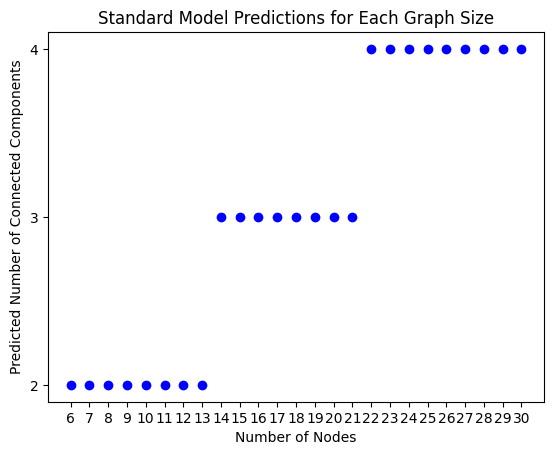

In [ ]:
plt.scatter(Nlist, preds_for_all_N, color='blue', label='Scatter Plot')
plt.title('Standard Model Predictions for Each Graph Size')
plt.xlabel('Number of Nodes')
plt.ylabel('Predicted Number of Connected Components')
plt.xticks(range(min(Nlist), max(Nlist) + 1))
plt.yticks(range(min(preds_for_all_N), max(preds_for_all_N) + 1))
plt.show()